In [1]:
import numpy as np
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

BATCH_SIZE=30
IMG_SIZE=(48,48)
INPUT_SIZE=(224,224)
SEED=11
VALIDATION_SPLIT=0.2

train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                 shuffle=True,
                                                                 seed=SEED,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=INPUT_SIZE, 
                                                                 validation_split=VALIDATION_SPLIT,
                                                                 label_mode='categorical',
                                                                 subset='training',
                                                                 color_mode='rgb')
val_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                 shuffle=True,
                                                                 seed=SEED,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=INPUT_SIZE, 
                                                                 validation_split=VALIDATION_SPLIT,
                                                                 label_mode='categorical',
                                                                 subset='validation',
                                                                 color_mode='rgb')
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 seed=SEED,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=INPUT_SIZE,
                                                                 label_mode='categorical',
                                                                 color_mode='rgb')

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


Class name:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of class:  7


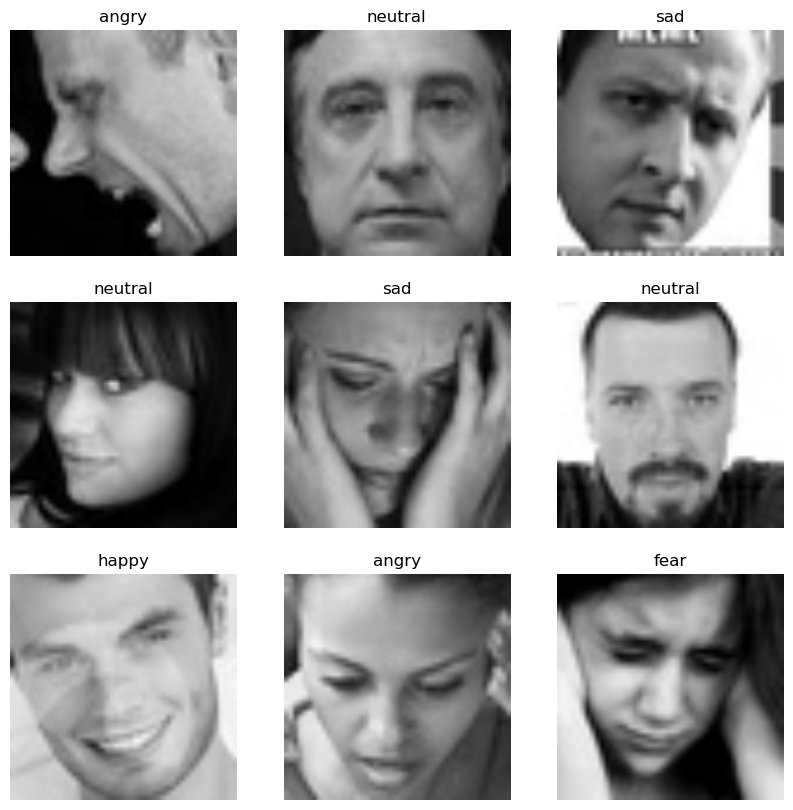

In [3]:
class_names = train_data.class_names
print('Class name: ',class_names)
num_classes=len(class_names)
print('Number of class: ',num_classes)

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

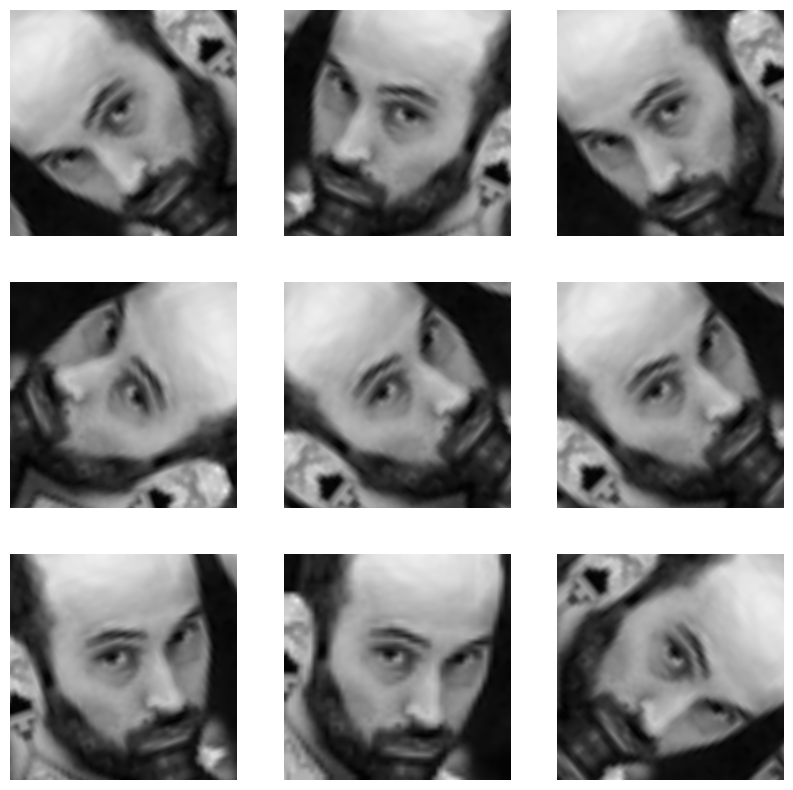

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Rescaling(1./255)
])
for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [6]:
INPUT_MODEL_SIZE=INPUT_SIZE+(3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=INPUT_MODEL_SIZE,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 [==============================] - 3s 0us/step


In [7]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(256, activation="relu")
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))
inputs = tf.keras.Input(shape=INPUT_MODEL_SIZE)

x = data_augmentation(inputs)
x = base_model(x, training=True)
x = global_average_layer(x)
x = dense_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(num_classes, activation="softmax",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))
# ])

In [8]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

In [9]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.math.exp(-ce_loss)
        focal_loss = alpha * tf.math.pow((1 - pt), gamma) * ce_loss
        return focal_loss
    return focal_loss_fixed

In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

In [11]:
model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [12]:
num_epochs = 10
class_weights = {
            0:1.02660468,
            1:5.40661861,
            2:1.00104606,
            3:0.56843877,
            4:0.84912748,
            5:1.29337298,
            6:0.82603942,
}

history=model.fit(
    train_data,
    epochs=num_epochs,
    validation_data=val_data
    #class_weight=class_weights
    #callbacks=[reduce_lr]
)

Epoch 1/10
766/766 [==============================] - 168s 201ms/step - loss: 0.4540 - accuracy: 0.2836 - val_loss: 0.2812 - val_accuracy: 0.3740
Epoch 2/10
766/766 [==============================] - 150s 195ms/step - loss: 0.2805 - accuracy: 0.3834 - val_loss: 0.2601 - val_accuracy: 0.4168
Epoch 3/10
766/766 [==============================] - 149s 194ms/step - loss: 0.2635 - accuracy: 0.4174 - val_loss: 0.2381 - val_accuracy: 0.4654
Epoch 4/10
766/766 [==============================] - 148s 193ms/step - loss: 0.2507 - accuracy: 0.4422 - val_loss: 0.2219 - val_accuracy: 0.4889
Epoch 5/10
766/766 [==============================] - 148s 193ms/step - loss: 0.2409 - accuracy: 0.4624 - val_loss: 0.2191 - val_accuracy: 0.4976
Epoch 6/10
766/766 [==============================] - 149s 194ms/step - loss: 0.2316 - accuracy: 0.4801 - val_loss: 0.2176 - val_accuracy: 0.5008
Epoch 7/10
766/766 [==============================] - 150s 195ms/step - loss: 0.2251 - accuracy: 0.4875 - val_loss: 0.2062 -

In [13]:
test_loss, test_acc = model.evaluate(test_data)

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")

240/240 [==============================] - 17s 70ms/step - loss: 0.1932 - accuracy: 0.5495
Test Loss: 0.1932 - Test Accuracy: 0.5495


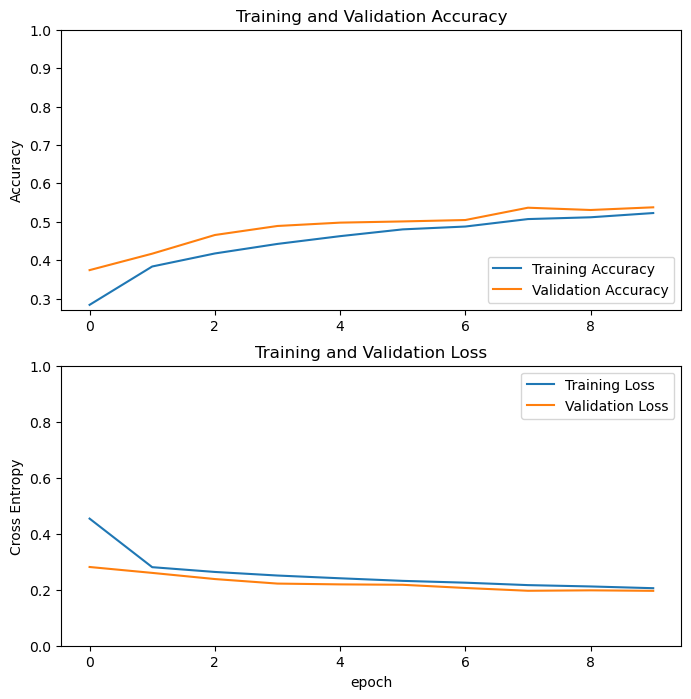

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

240/240 [==============================] - 16s 61ms/step


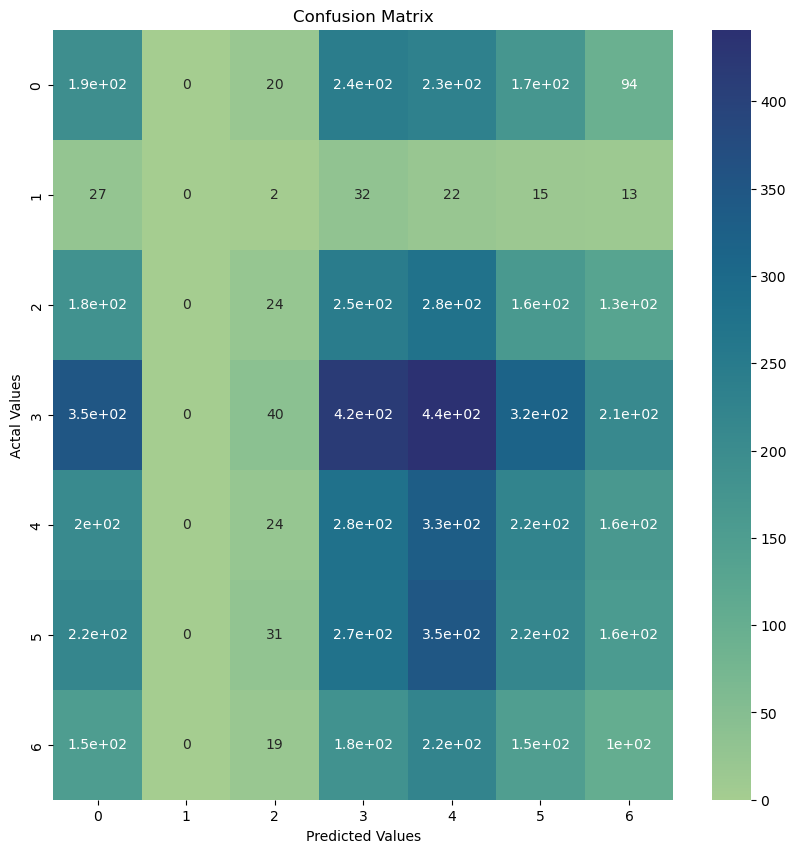

In [15]:
y_pred_probabilities = model.predict(test_data)
y_pred = np.argmax(y_pred_probabilities, axis=1)
y_true = np.concatenate([np.argmax(y,axis=1) for _, y in test_data], axis=0)

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, annot=True,cmap="crest")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [16]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, activation="softmax",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))
])
model.compile(loss=focal_loss(gamma=2.0, alpha=0.25),
              metrics=["accuracy"],
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate/10))
model.summary()


Number of layers in the base model:  175
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 24,114,055
Trainable params: 10,516,487
Non-trainable params: 13,

In [17]:
fine_tune_epochs = 15
total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data
                         #class_weight=class_weights,
                         #callbacks=[reduce_lr]
                        )

Epoch 10/25
766/766 [==============================] - 74s 86ms/step - loss: 1.1914 - accuracy: 0.2563 - val_loss: 0.7124 - val_accuracy: 0.2695
Epoch 11/25
766/766 [==============================] - 66s 86ms/step - loss: 0.4870 - accuracy: 0.2600 - val_loss: 0.3594 - val_accuracy: 0.2637
Epoch 12/25
766/766 [==============================] - 65s 85ms/step - loss: 0.3418 - accuracy: 0.2615 - val_loss: 0.3282 - val_accuracy: 0.2597
Epoch 13/25
766/766 [==============================] - 65s 85ms/step - loss: 0.3261 - accuracy: 0.2603 - val_loss: 0.3208 - val_accuracy: 0.2592
Epoch 14/25
766/766 [==============================] - 67s 87ms/step - loss: 0.3216 - accuracy: 0.2626 - val_loss: 0.3180 - val_accuracy: 0.2611
Epoch 15/25
766/766 [==============================] - 67s 87ms/step - loss: 0.3195 - accuracy: 0.2623 - val_loss: 0.3167 - val_accuracy: 0.2616
Epoch 16/25
766/766 [==============================] - 67s 87ms/step - loss: 0.3180 - accuracy: 0.2634 - val_loss: 0.3159 - val_ac

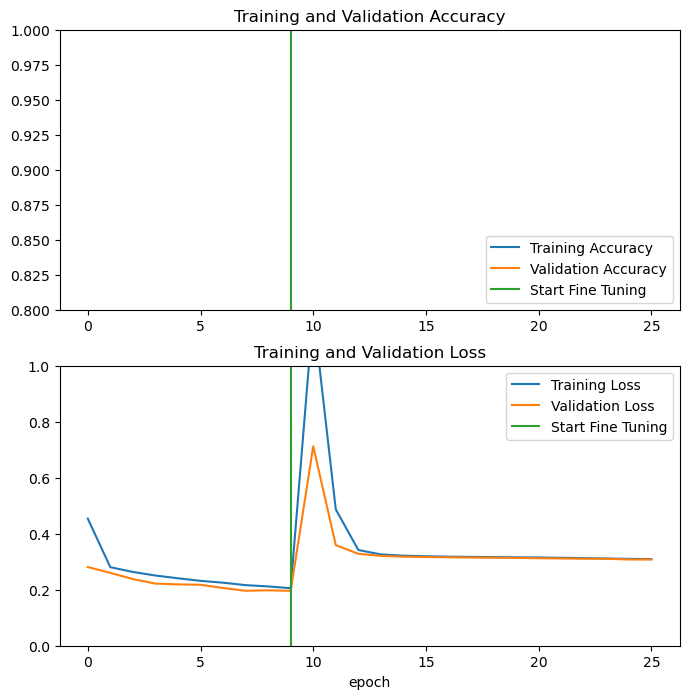

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([num_epochs-1,num_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([num_epochs-1,num_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)

240/240 [==============================] - 14s 59ms/step - loss: 0.3068 - accuracy: 0.3135
Test accuracy : 0.31345778703689575


240/240 [==============================] - 14s 54ms/step


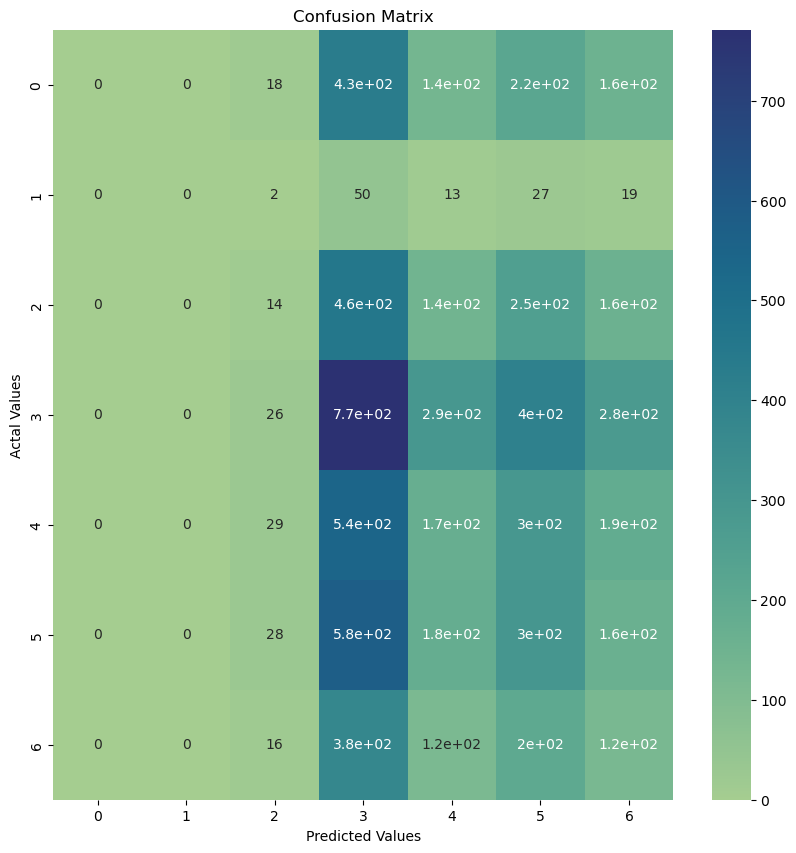

In [20]:

y_pred_probabilities = model.predict(test_data)
y_pred = np.argmax(y_pred_probabilities, axis=1)
y_true = np.concatenate([np.argmax(y,axis=1) for _, y in test_data], axis=0)

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, annot=True,cmap="crest")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [21]:
# image_batch, label_batch = next(iter(train_data))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [22]:
# base_model.trainable = False
# #base_model.summary()
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# prediction_layer = tf.keras.layers.Dense(num_classes,activation='softmax')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [23]:
# inputs = tf.keras.Input(shape=INPUT_MODEL_SIZE)
# x = data_augmentation(inputs)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)
# model.summary()

In [24]:
# base_learning_rate = 0.001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# initial_epochs = 10
# loss0, accuracy0 = model.evaluate(val_data)
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [25]:
# history = model.fit(train_data,
#                     epochs=initial_epochs,
#                     validation_data=val_data)

In [26]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [27]:
# base_model.trainable = True

# print("Number of layers in the base model: ", len(base_model.layers))

# fine_tune_at = 100

# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False

In [28]:
# model.compile(loss='categorical_crossentropy',
#               optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#               metrics=['accuracy'])
# fine_tune_epochs = 10
# total_epochs =  initial_epochs + fine_tune_epochs

# history_fine = model.fit(train_data,
#                          epochs=total_epochs,
#                          initial_epoch=history.epoch[-1],
#                          validation_data=val_data)

In [29]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [30]:
# loss, accuracy = model.evaluate(test_datas)
# print('Test accuracy :', accuracy)

In [31]:
#model.save('ResNet50.h5')

In [32]:

# image_batch, label_batch = test_data.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# predictions = tf.nn.softmax(predictions)
# predictions = tf.argmax(predictions)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

In [33]:
# IMG_SHAPE=IMG_SIZE+(1,)
# print('Number of classes :',num_classes)
# EPOCHS=50
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                             patience=7,
#                                             verbose=1,
#                                             mode='min', 
#                                             restore_best_weights=True)

# # Create the LeNet-5 model
# model = Sequential()

# # First convolutional layer
# model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=IMG_SHAPE))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# #model.add(Dropout(0.25))

# # Second convolutional layer
# model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# # Flatten the input for the fully connected layers
# model.add(Flatten())

# # Fully connected layers
# model.add(Dense(120, activation='relu'))
# model.add(Dense(84, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

# # Train the model
# history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data) #callbacks=[callback]

# # Save the trained model
# model.save('LeNet5_grayscale_classification_model.h5')

In [34]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()